<h1 style="
    display: inline-block;
    background: linear-gradient(135deg, #1f77b4, #17becf);
    color: white;
    padding: 20px 40px;
    font-size: 42px;
    font-weight: 600;
    line-height: 1.2;
    border-radius: 8px;
    font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, sans-serif;
    text-align: center;
    box-shadow: 0 4px 12px rgba(31, 119, 180, 0.3);
    margin: 20px 0;
    border-left: 6px solid #20a0ff;
">
📦 Import Libraries
</h1>

In [39]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import re
from bidi.algorithm import get_display
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import datetime
import holidays

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')
import os

In [40]:
df = pd.read_csv('/kaggle/input/padma-bridge-toll-dataset/Padma_Bridge - Traffic.csv',parse_dates=['Date'], dayfirst=True)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M:%S')
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

Now we check for missing values per column

In [41]:
df.head()

,Date,Traffic_Mawa,Traffic_Jajira,Cash_Mawa,Cash_Jajira,Total_Traffic,Total_Cash
0,2022-01-07,13801,12597,16542100,15111100,26398,31653200
1,2022-01-08,6071,6259,9195100,9670800,12330,18865900
2,2022-01-09,6414,6154,9588950,9781100,12568,19370050
3,2022-01-10,6887,7653,10002700,11063300,14540,21066000
4,2022-01-11,6184,6430,9729450,10116450,12614,19845900


In [42]:
print("---- Missing values per column------")
print(df.isnull().sum())

---- Missing values per column------
Date              0
Traffic_Mawa      0
Traffic_Jajira    0
Cash_Mawa         0
Cash_Jajira       0
Total_Traffic     0
Total_Cash        0
dtype: int64


Since there is no missing values, we don't take any other actions. Otherwise, we would have filled out missing values using forward fill method.

In [43]:
df['Total_Cash'].isnull().any()

False

Total cash is an object here. So we convert it into float.

In [44]:
df['Total_Cash'] = (
    df['Total_Cash']
    .astype(str)                
    .str.replace(',', '')      
    .str.strip()                
)

df['Total_Cash'] = pd.to_numeric(df['Total_Cash'], errors='coerce')

In [45]:
df['Total_Cash'] = df['Total_Cash'].fillna(df['Cash_Mawa'] + df['Cash_Jajira'])

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170 entries, 0 to 1169
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            1170 non-null   datetime64[ns]
 1   Traffic_Mawa    1170 non-null   int64         
 2   Traffic_Jajira  1170 non-null   int64         
 3   Cash_Mawa       1170 non-null   int64         
 4   Cash_Jajira     1170 non-null   int64         
 5   Total_Traffic   1170 non-null   int64         
 6   Total_Cash      1170 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 64.1 KB


<h1 style="
    display: inline-block;
    background: linear-gradient(135deg, #1f77b4, #17becf);
    color: white;
    padding: 20px 40px;
    font-size: 42px;
    font-weight: 600;
    line-height: 1.2;
    border-radius: 8px;
    font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, sans-serif;
    text-align: center;
    box-shadow: 0 4px 12px rgba(31, 119, 180, 0.3);
    margin: 20px 0;
    border-left: 6px solid #20a0ff;
">
⚙️ Feature Engineering
</h1>

We mark Friday and Saturday as weekday, and then set offday as True where weekday = 4 or 5. Then we mark Independence day, Martyr day etc as Holidays. This code breaks each date into year, month, and day, and marks weekends. It also adds the weekday number, the day of the year, the week number, and the quarter. Then it checks Bangladesh holidays (plus some extra ones for Quota Movement in 2024) and marks those dates as holidays. To handle repeating cycles like months, days, and weekdays, I used sine and cosine versions so the data understands time is circular.

In [47]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['isWeekend'] =  df['Date'].dt.weekday.isin([4,5]).astype(int)

df['DayOfWeek'] = df['Date'].dt.dayofweek
df['DayOfYear'] = df['Date'].dt.dayofyear
df['WeekOfYear'] = df['Date'].dt.isocalendar().week
df['Quarter'] = df['Date'].dt.quarter

In [48]:
bd_holidays = holidays.Bangladesh(years=df['Year'].unique())
official_holidays = set(bd_holidays.keys())

extra_holidays = {
    datetime.date(2025, 8, 5),
    datetime.date(2024, 8, 5)
}

all_holidays = official_holidays.union(extra_holidays)

df['isHoliday'] = df['Date'].dt.date.isin(all_holidays).astype(int)

In [49]:
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
df['Weekend_Holiday'] = df['isWeekend'] * df['isHoliday']
df['Holiday_Month'] = df['isHoliday'] * df['Month']

In [50]:
df.shape

(1170, 24)

In [51]:
df.columns

Index(['Date', 'Traffic_Mawa', 'Traffic_Jajira', 'Cash_Mawa', 'Cash_Jajira',
       'Total_Traffic', 'Total_Cash', 'Year', 'Month', 'Day', 'isWeekend',
       'DayOfWeek', 'DayOfYear', 'WeekOfYear', 'Quarter', 'isHoliday',
       'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', 'DayOfWeek_sin',
       'DayOfWeek_cos', 'Weekend_Holiday', 'Holiday_Month'],
      dtype='object')

In [52]:
df.head()

,Date,Traffic_Mawa,Traffic_Jajira,Cash_Mawa,Cash_Jajira,Total_Traffic,Total_Cash,Year,Month,Day,...,Quarter,isHoliday,Month_sin,Month_cos,Day_sin,Day_cos,DayOfWeek_sin,DayOfWeek_cos,Weekend_Holiday,Holiday_Month
0,2022-01-07,13801,12597,16542100,15111100,26398,31653200.0,2022,1,7,...,1,0,0.5,0.866025,0.988468,0.151428,-0.433884,-0.900969,0,0
1,2022-01-08,6071,6259,9195100,9670800,12330,18865900.0,2022,1,8,...,1,0,0.5,0.866025,0.998717,-0.050649,-0.974928,-0.222521,0,0
2,2022-01-09,6414,6154,9588950,9781100,12568,19370050.0,2022,1,9,...,1,0,0.5,0.866025,0.968077,-0.250653,-0.781831,0.623490,0,0
3,2022-01-10,6887,7653,10002700,11063300,14540,21066000.0,2022,1,10,...,1,0,0.5,0.866025,0.897805,-0.440394,0.000000,1.000000,0,0
4,2022-01-11,6184,6430,9729450,10116450,12614,19845900.0,2022,1,11,...,1,0,0.5,0.866025,0.790776,-0.612106,0.781831,0.623490,0,0


In [53]:
target_cols = ['Traffic_Mawa','Traffic_Jajira','Cash_Mawa','Cash_Jajira', 'Total_Cash', 'Total_Traffic']

In [54]:
df.describe()

,Date,Traffic_Mawa,Traffic_Jajira,Cash_Mawa,Cash_Jajira,Total_Traffic,Total_Cash,Year,Month,Day,...,Quarter,isHoliday,Month_sin,Month_cos,Day_sin,Day_cos,DayOfWeek_sin,DayOfWeek_cos,Weekend_Holiday,Holiday_Month
count,1170,1170.000000,1170.000000,1.170000e+03,1.170000e+03,1170.000000,1.170000e+03,1170.000000,1170.000000,1170.000000,...,1170.000000,1170.000000,1.170000e+03,1.170000e+03,1.170000e+03,1170.000000,1170.000000,1170.000000,1170.000000,1170.000000
mean,2024-01-30 00:29:32.307692288,8825.338462,8940.311966,1.136663e+07,1.169981e+07,17771.069231,2.281838e+07,2023.578632,6.535897,15.778632,...,2.517094,0.020513,-2.371685e-02,-2.984494e-02,9.841275e-03,-0.017907,0.002294,0.000711,0.005128,0.115385
min,2022-01-07 00:00:00,6.000000,2188.000000,1.773650e+06,2.185100e+06,3781.000000,4.019800e+06,2022.000000,1.000000,1.000000,...,1.000000,0.000000,-1.000000e+00,-1.000000e+00,-9.987165e-01,-0.994869,-0.974928,-0.900969,0.000000,0.000000
25%,2023-04-14 06:00:00,7282.750000,7561.500000,1.010235e+07,1.048510e+07,15008.500000,2.061912e+07,2023.000000,4.000000,8.000000,...,2.000000,0.000000,-8.660254e-01,-8.660254e-01,-7.247928e-01,-0.758758,-0.781831,-0.900969,0.000000,0.000000
50%,2024-01-31 12:00:00,8274.000000,8530.000000,1.086450e+07,1.126490e+07,16924.500000,2.212432e+07,2024.000000,7.000000,16.000000,...,3.000000,0.000000,-2.449294e-16,-1.836970e-16,-2.449294e-16,-0.050649,0.000000,-0.222521,0.000000,0.000000
75%,2024-11-18 18:00:00,9645.000000,9924.500000,1.215046e+07,1.234472e+07,19406.500000,2.440775e+07,2024.000000,9.000000,23.000000,...,3.000000,0.000000,5.000000e-01,5.000000e-01,7.247928e-01,0.688967,0.781831,0.623490,0.000000,0.000000
max,2025-12-08 00:00:00,35985.000000,29164.000000,1.040765e+08,1.133480e+08,52487.000000,5.432800e+07,2025.000000,12.000000,31.000000,...,4.000000,1.000000,1.000000e+00,1.000000e+00,9.987165e-01,1.000000,0.974928,1.000000,1.000000,12.000000
std,NaN,2961.990979,2648.521343,3.672648e+06,4.581807e+06,5092.359483,4.533926e+06,0.997544,3.391101,8.786395,...,1.100648,0.141807,7.041317e-01,7.096475e-01,7.198713e-01,0.694423,0.707769,0.707045,0.071458,0.919991


<h1 style="
    display: inline-block;
    background: linear-gradient(135deg, #1f77b4, #17becf);
    color: white;
    padding: 20px 40px;
    font-size: 42px;
    font-weight: 600;
    line-height: 1.2;
    border-radius: 8px;
    font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, sans-serif;
    text-align: center;
    box-shadow: 0 4px 12px rgba(31, 119, 180, 0.3);
    margin: 20px 0;
    border-left: 6px solid #20a0ff;
">
🧪 Model Training
</h1>

This portion of the code looks at each target_cols and creates new columns that contains values from:

- 1 day ago
- 7 days ago
- 14 days ago
- 30 days ago

This helps our model to see past values easily. Example: our model can now "remember" what happened last day, last week, two weeks ago and last month.

In [55]:
lags=[1, 7, 14, 30]
    
for col in target_cols:
    for lag in lags:
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)

For each column, it looks at the past 7, 14, and 30 days and calculates:

- **Rolling mean:** average of the past days

- **Rolling standard deviation:** how much the past values vary

- **Rolling min/max:** lowest and highest values in the past days

- **Exponential weighted mean:** like an average that gives more weight to recent days

In [56]:
windows=[7, 14, 30]

for col in target_cols:
    for window in windows:
        df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window).mean()
        df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window).std()
        df[f'{col}_rolling_min_{window}'] = df[col].rolling(window=window).min()
        df[f'{col}_rolling_max_{window}'] = df[col].rolling(window=window).max()
        
        # Exponential weighted mean
        df[f'{col}_ewm_mean_{window}'] = df[col].ewm(span=window).mean()

In [57]:
print(f"Features created. Shape before dropping NaN: {df.shape}")

df = df.dropna()

print(f"Shape after dropping NaN: {df.shape}")

Features created. Shape before dropping NaN: (1170, 138)
Shape after dropping NaN: (1140, 138)


In [58]:
exclude_cols = target_cols + ['Date']
feature_cols = [col for col in df.columns if col not in exclude_cols]

In [59]:
X = df[feature_cols]
y = df[target_cols]

print(f"Final feature set: {len(feature_cols)} features")

Final feature set: 131 features


In [60]:
print("All feature names:")
print(feature_cols)

All feature names:
['Year', 'Month', 'Day', 'isWeekend', 'DayOfWeek', 'DayOfYear', 'WeekOfYear', 'Quarter', 'isHoliday', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Weekend_Holiday', 'Holiday_Month', 'Traffic_Mawa_lag_1', 'Traffic_Mawa_lag_7', 'Traffic_Mawa_lag_14', 'Traffic_Mawa_lag_30', 'Traffic_Jajira_lag_1', 'Traffic_Jajira_lag_7', 'Traffic_Jajira_lag_14', 'Traffic_Jajira_lag_30', 'Cash_Mawa_lag_1', 'Cash_Mawa_lag_7', 'Cash_Mawa_lag_14', 'Cash_Mawa_lag_30', 'Cash_Jajira_lag_1', 'Cash_Jajira_lag_7', 'Cash_Jajira_lag_14', 'Cash_Jajira_lag_30', 'Total_Cash_lag_1', 'Total_Cash_lag_7', 'Total_Cash_lag_14', 'Total_Cash_lag_30', 'Total_Traffic_lag_1', 'Total_Traffic_lag_7', 'Total_Traffic_lag_14', 'Total_Traffic_lag_30', 'Traffic_Mawa_rolling_mean_7', 'Traffic_Mawa_rolling_std_7', 'Traffic_Mawa_rolling_min_7', 'Traffic_Mawa_rolling_max_7', 'Traffic_Mawa_ewm_mean_7', 'Traffic_Mawa_rolling_mean_14', 'Traffic_Mawa_rolling_std_14', 'Traffic_Mawa_rolling_

`TimeSeriesSplit(n_splits=5)` splits our data into 5 sequential folds without shuffling, which is important for time-dependent data. `list(tsa_main.split(X))[-1]` takes the last split, giving the most recent chunk of data as the test set. `train_idx` and `test_idx` are the row indices for the training and test sets.

In [61]:
tsa_main = TimeSeriesSplit(n_splits=5)
train_idx, test_idx = list(tsa_main.split(X))[-1] 

In [62]:
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Training date range: {df.iloc[train_idx]['Date'].min()} to {df.iloc[train_idx]['Date'].max()}")
print(f"Test date range: {df.iloc[test_idx]['Date'].min()} to {df.iloc[test_idx]['Date'].max()}")


Training set: 950 samples
Test set: 190 samples
Training date range: 2022-06-07 00:00:00 to 2025-03-07 00:00:00
Test date range: 2025-03-08 00:00:00 to 2025-12-08 00:00:00


Now, we standardize the data so each feature has mean 0 and standard deviation 1. We are using MultipleOutputRegressor because this model allows the random forest to **predict multiple target columns at once.**

In [63]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [75]:
param_grid = {
    'num_leaves': [31, 63, 127],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [500, 1000, 1500],
    'feature_fraction': [0.7, 0.8],
    'bagging_fraction': [0.7, 0.8],
    'bagging_freq': [3, 5]
}

In [65]:
best_models = {}
results = []

In [76]:
for col in target_cols:
    print(f"\nGrid search for target: {col}")
    lgbm = LGBMRegressor(objective='regression', random_state=42, n_jobs=-1)

    grid = GridSearchCV(
        estimator=lgbm,
        param_grid=param_grid,
        cv=2,
        scoring='neg_mean_absolute_error',
        verbose=1,
        pre_dispatch='2*n_jobs'
    )

    grid.fit(X_train_scaled, y_train[col])
    best_model = grid.best_estimator_
    best_models[col] = best_model

    preds = best_model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test[col], preds)
    mse = mean_squared_error(y_test[col], preds)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test[col] - preds) / y_test[col])) * 100
    r2 = r2_score(y_test[col], preds)

    results.append({
        'Target': col,
        'Best Params': grid.best_params_,
        'MAE': round(mae, 3),
        'MSE': round(mse, 3),
        'RMSE': round(rmse, 3),
        'MAPE (%)': round(mape, 2),
        'R²': round(r2, 3)
    })


Grid search for target: Traffic_Mawa
Fitting 2 folds for each of 216 candidates, totalling 432 fits

Grid search for target: Traffic_Jajira
Fitting 2 folds for each of 216 candidates, totalling 432 fits

Grid search for target: Cash_Mawa
Fitting 2 folds for each of 216 candidates, totalling 432 fits

Grid search for target: Cash_Jajira
Fitting 2 folds for each of 216 candidates, totalling 432 fits

Grid search for target: Total_Cash
Fitting 2 folds for each of 216 candidates, totalling 432 fits

Grid search for target: Total_Traffic
Fitting 2 folds for each of 216 candidates, totalling 432 fits


In [77]:
results_df = pd.DataFrame(results)
pd.set_option('display.max_colwidth', None)
print("\nOptimized Model Summary:")
display(results_df)


Optimized Model Summary:


,Target,Best Params,MAE,MSE,RMSE,MAPE (%),R²
0,Traffic_Mawa,"{'bagging_fraction': 0.8, 'bagging_freq': 3, 'feature_fraction': 0.8, 'learning_rate': 0.05, 'min_child_samples': 20, 'n_estimators': 300, 'num_leaves': 31}",1129.756,4.478299e+06,2116.199,10.63,0.645
1,Traffic_Jajira,"{'bagging_fraction': 0.8, 'bagging_freq': 3, 'feature_fraction': 0.8, 'learning_rate': 0.05, 'min_child_samples': 20, 'n_estimators': 300, 'num_leaves': 31}",1253.567,4.837959e+06,2199.536,11.55,0.501
2,Cash_Mawa,"{'bagging_fraction': 0.8, 'bagging_freq': 3, 'feature_fraction': 0.9, 'learning_rate': 0.05, 'min_child_samples': 20, 'n_estimators': 300, 'num_leaves': 31}",942365.515,3.057141e+12,1748468.236,7.39,0.615
3,Cash_Jajira,"{'bagging_fraction': 0.8, 'bagging_freq': 3, 'feature_fraction': 0.8, 'learning_rate': 0.05, 'min_child_samples': 20, 'n_estimators': 300, 'num_leaves': 31}",1201711.243,4.035604e+12,2008881.399,9.84,0.322
4,Total_Cash,"{'bagging_fraction': 0.8, 'bagging_freq': 3, 'feature_fraction': 0.8, 'learning_rate': 0.05, 'min_child_samples': 20, 'n_estimators': 300, 'num_leaves': 31}",1646874.888,7.922760e+12,2814739.772,6.52,0.687
5,Total_Traffic,"{'bagging_fraction': 0.8, 'bagging_freq': 3, 'feature_fraction': 0.8, 'learning_rate': 0.1, 'min_child_samples': 20, 'n_estimators': 300, 'num_leaves': 31}",1938.852,1.079532e+07,3285.624,8.91,0.671
6,Traffic_Mawa,"{'bagging_fraction': 0.7, 'bagging_freq': 5, 'feature_fraction': 0.8, 'learning_rate': 0.01, 'n_estimators': 1000, 'num_leaves': 31}",1114.997,4.767866e+06,2183.544,10.13,0.622
7,Traffic_Jajira,"{'bagging_fraction': 0.7, 'bagging_freq': 5, 'feature_fraction': 0.7, 'learning_rate': 0.01, 'n_estimators': 1000, 'num_leaves': 31}",1217.484,4.926871e+06,2219.656,11.18,0.492
8,Cash_Mawa,"{'bagging_fraction': 0.7, 'bagging_freq': 5, 'feature_fraction': 0.7, 'learning_rate': 0.01, 'n_estimators': 500, 'num_leaves': 31}",1018829.031,3.599610e+12,1897263.728,7.54,0.547
9,Cash_Jajira,"{'bagging_fraction': 0.7, 'bagging_freq': 5, 'feature_fraction': 0.8, 'learning_rate': 0.01, 'n_estimators': 500, 'num_leaves': 31}",1138476.026,3.531967e+12,1879352.782,8.97,0.407


<h1 style="
    display: inline-block;
    background: linear-gradient(135deg, #1f77b4, #17becf);
    color: white;
    padding: 20px 40px;
    font-size: 42px;
    font-weight: 600;
    line-height: 1.2;
    border-radius: 8px;
    font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, sans-serif;
    text-align: center;
    box-shadow: 0 4px 12px rgba(31, 119, 180, 0.3);
    margin: 20px 0;
    border-left: 6px solid #20a0ff;
">
📈 Making Predictions
</h1>

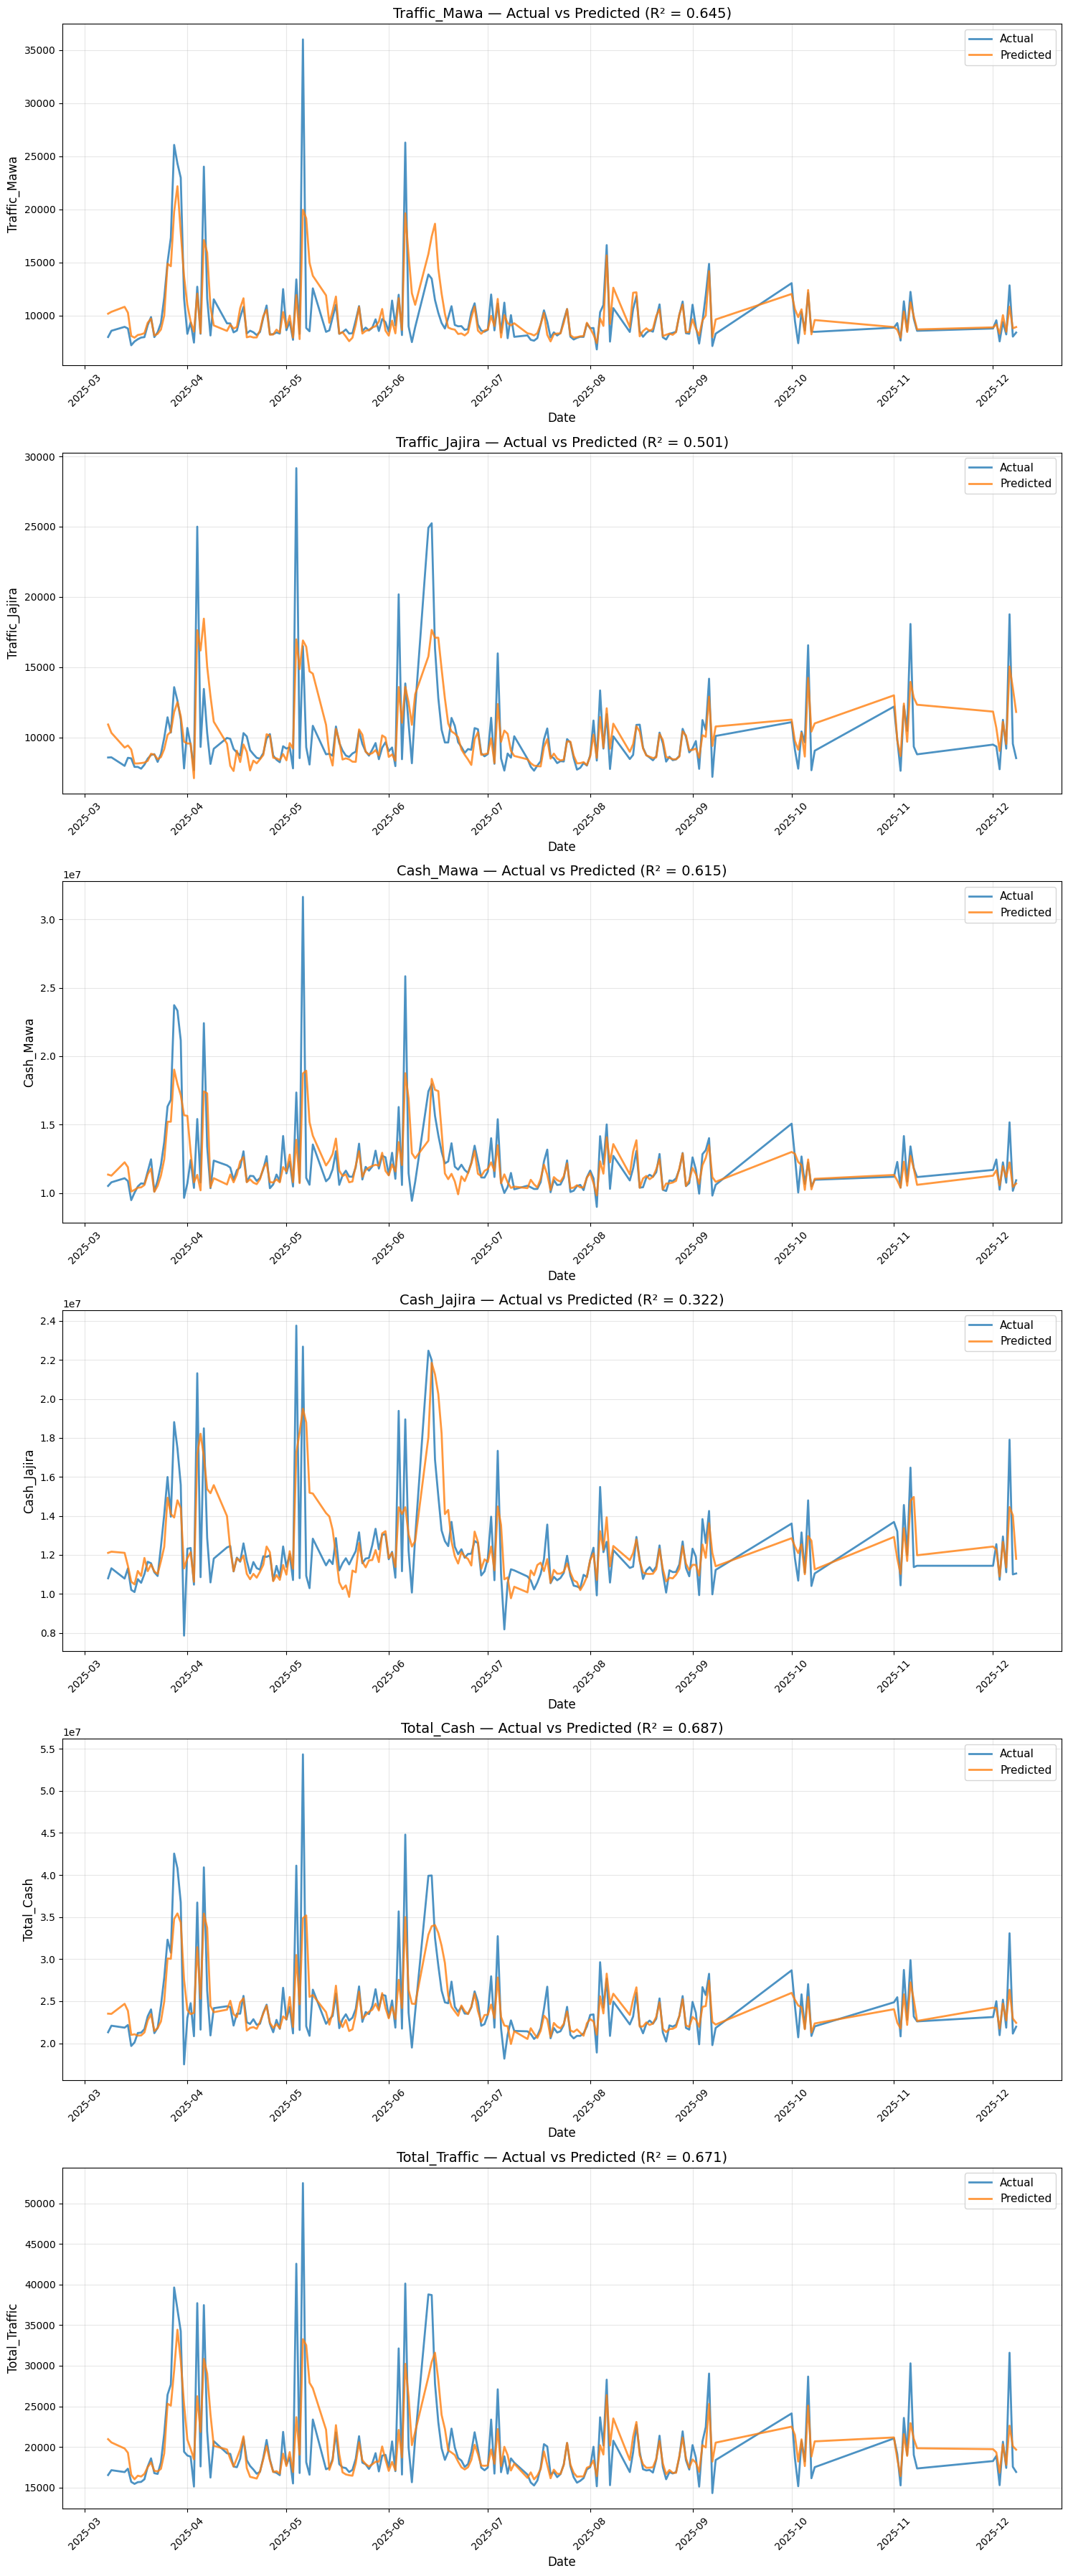

In [89]:
y_pred = np.zeros((len(X_test_scaled), len(target_cols)))

for i, col in enumerate(target_cols):
    y_pred[:, i] = best_models[col].predict(X_test_scaled)

fig, axes = plt.subplots(len(target_cols), 1, figsize=(15, 6*len(target_cols)))
if len(target_cols) == 1:
    axes = [axes]

test_dates = df.iloc[test_idx]['Date'].values

for i, col in enumerate(target_cols):
    axes[i].plot(test_dates, y_test[col].values, label='Actual', alpha=0.8, linewidth=2)
    axes[i].plot(test_dates, y_pred[:, i], label='Predicted', alpha=0.8, linewidth=2)
    axes[i].set_title(f'{col} — Actual vs Predicted (R² = {results_df.loc[results_df["Target"]==col, "R²"].values[0]:.3f})', fontsize=14)
    axes[i].set_xlabel('Date', fontsize=12)
    axes[i].set_ylabel(col, fontsize=12)
    axes[i].legend(fontsize=11)
    axes[i].grid(True, alpha=0.3)
    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()


Residual Analysis Summary:

Traffic_Mawa:
  Mean Residual        : -92.1873
  Std Residual         : 2181.5974
  Min Residual         : -10320.8495
  Max Residual         : 16034.5561
  Residual Mean/Std    : -0.0423



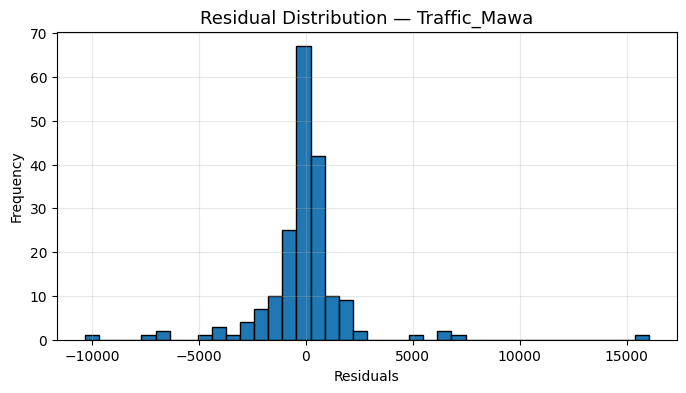

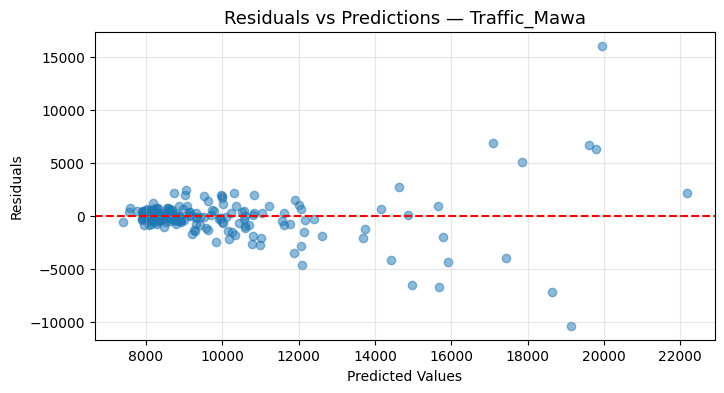

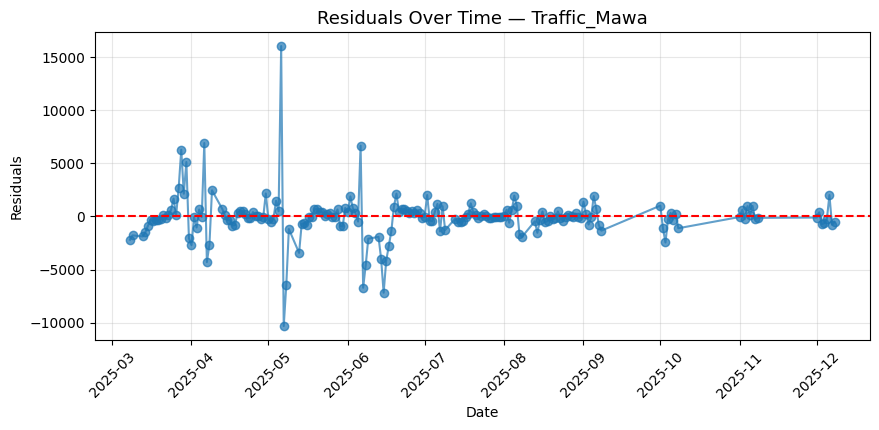

Traffic_Jajira:
  Mean Residual        : -189.9975
  Std Residual         : 2211.5089
  Min Residual         : -7154.9609
  Max Residual         : 12183.5279
  Residual Mean/Std    : -0.0859



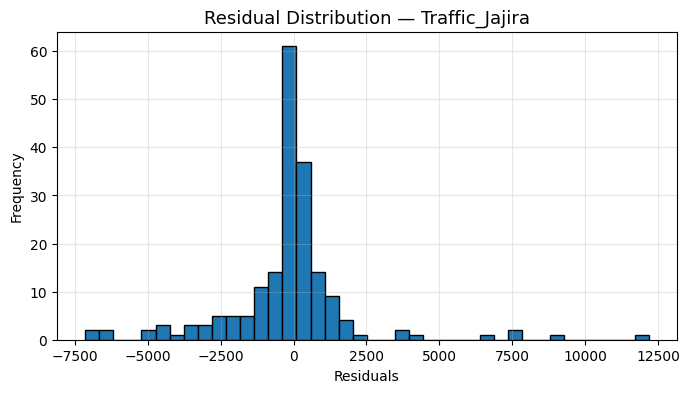

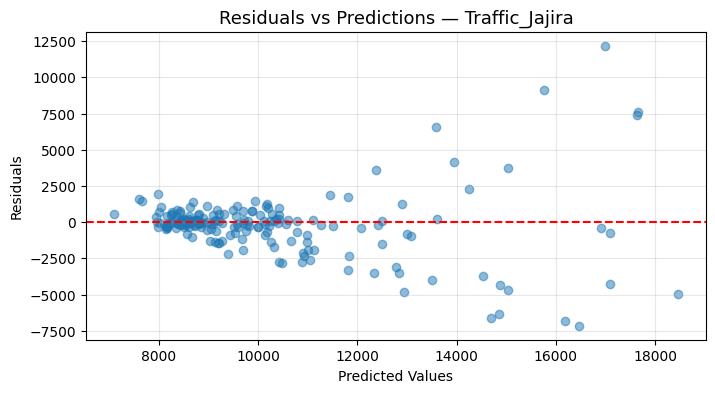

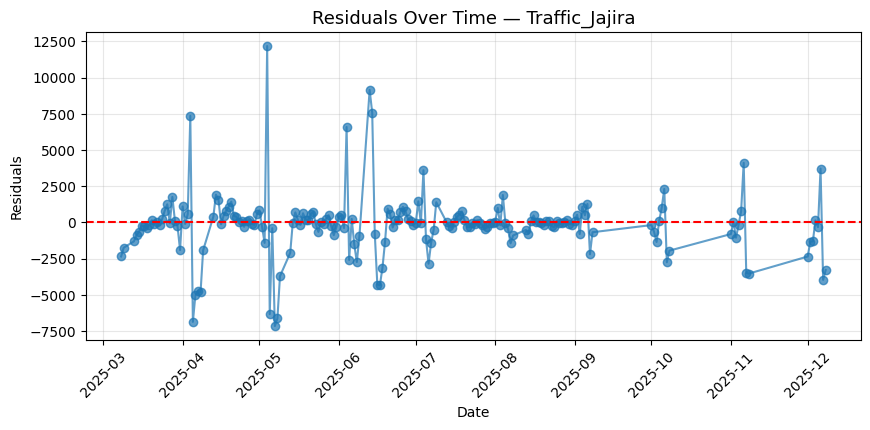

Cash_Mawa:
  Mean Residual        : 157813.6140
  Std Residual         : 1890688.8997
  Min Residual         : -7826476.7474
  Max Residual         : 12906049.5341
  Residual Mean/Std    : 0.0835



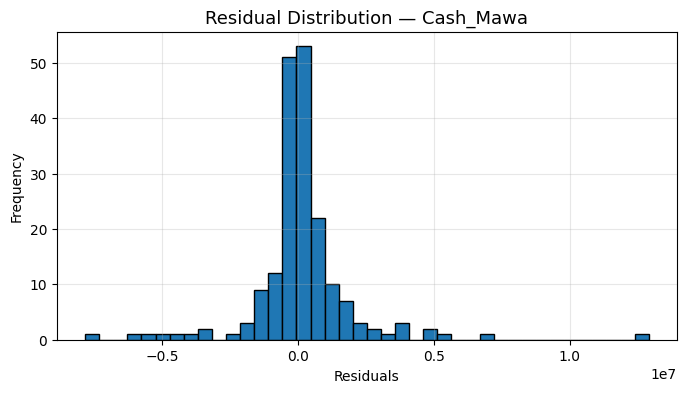

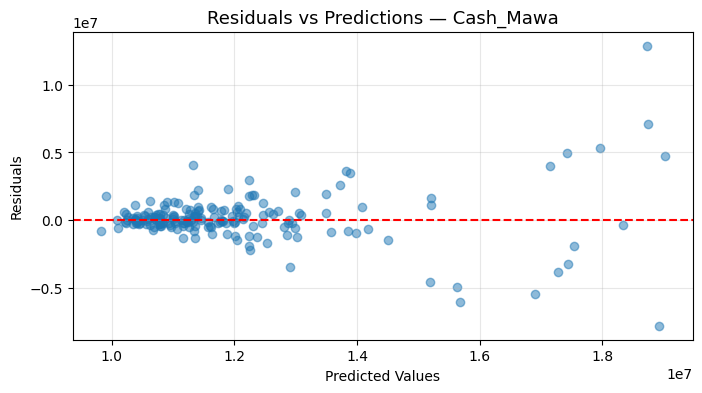

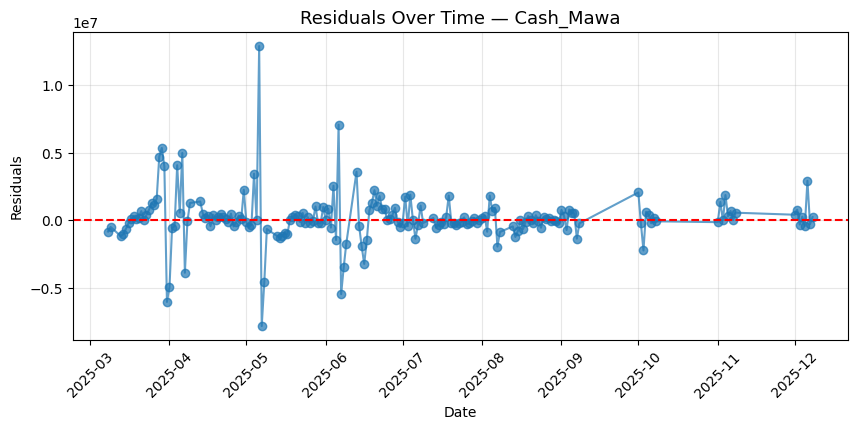

Cash_Jajira:
  Mean Residual        : -133281.1627
  Std Residual         : 1874620.7646
  Min Residual         : -7868037.9053
  Max Residual         : 6521938.0181
  Residual Mean/Std    : -0.0711



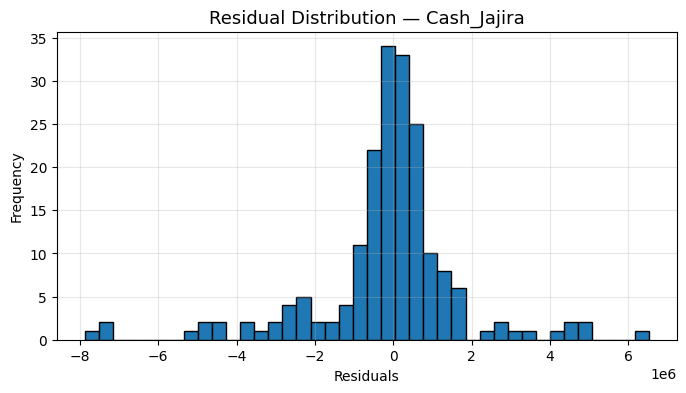

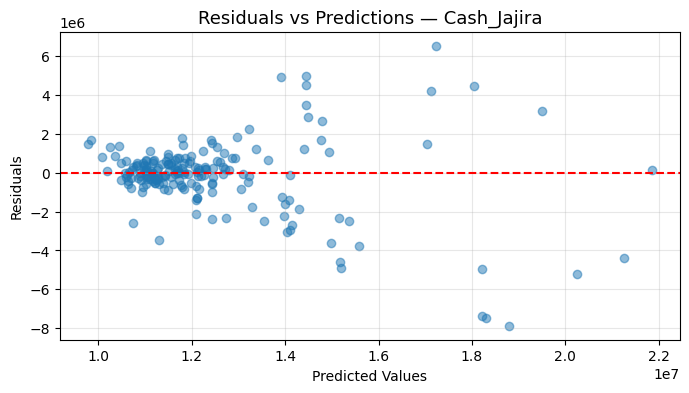

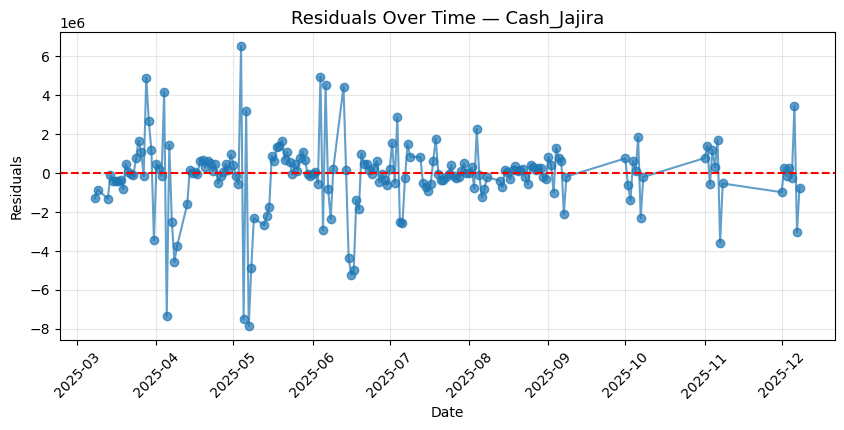

Total_Cash:
  Mean Residual        : 176960.1057
  Std Residual         : 3030997.2864
  Min Residual         : -13159369.0324
  Max Residual         : 19457802.1408
  Residual Mean/Std    : 0.0584



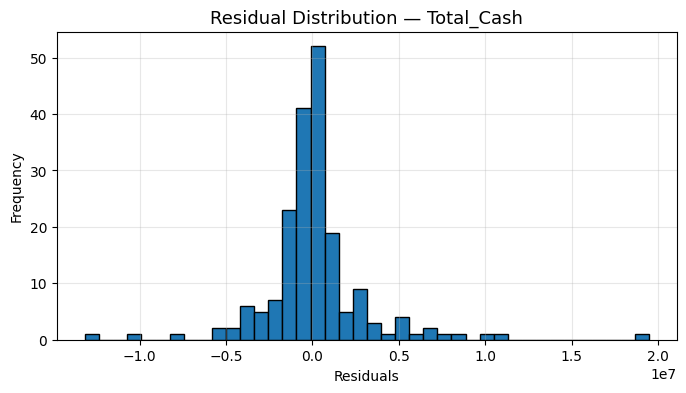

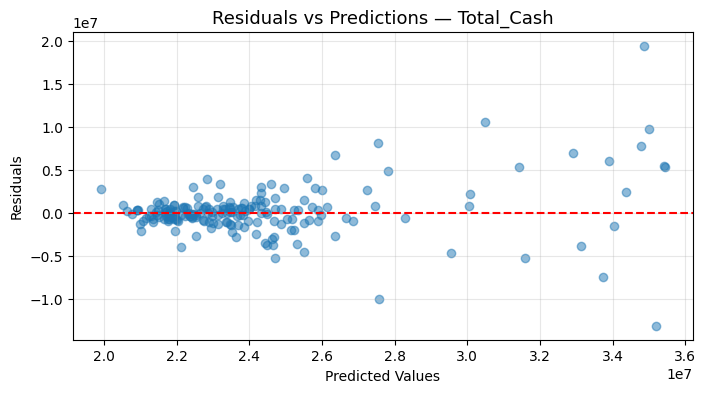

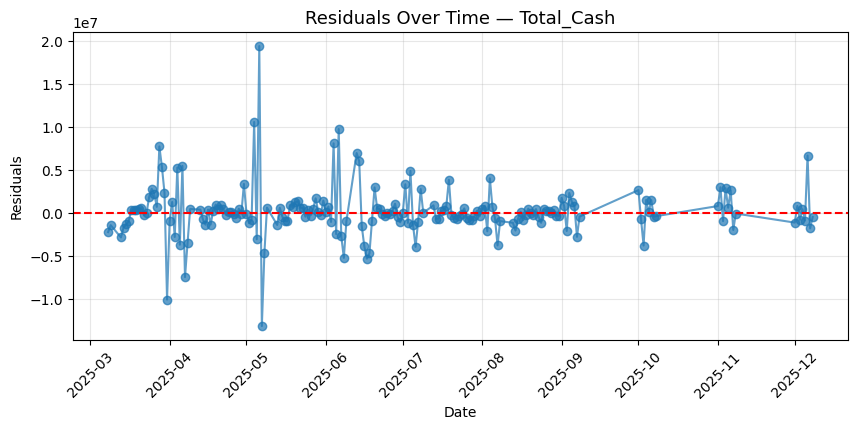

Total_Traffic:
  Mean Residual        : 74.6797
  Std Residual         : 3689.9374
  Min Residual         : -14408.9366
  Max Residual         : 19213.4387
  Residual Mean/Std    : 0.0202



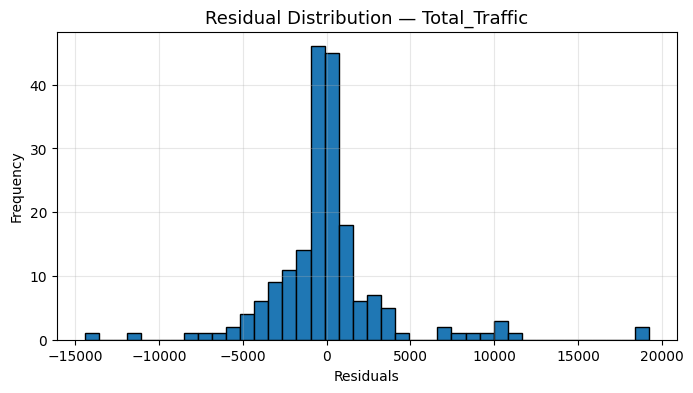

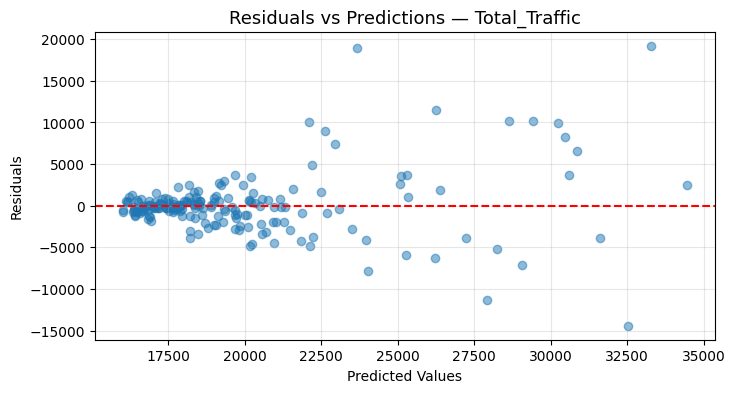

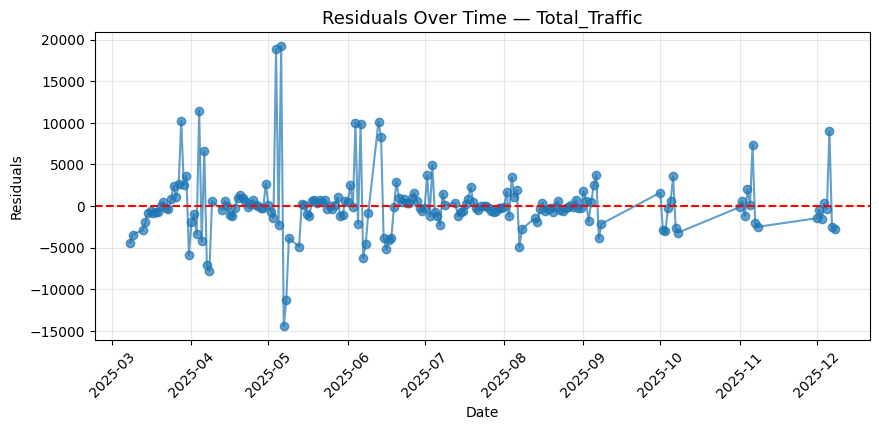

In [90]:
print("\nResidual Analysis Summary:\n")
for i, col in enumerate(target_cols):
    residuals = y_test[col].values - y_pred[:, i]

    mean_res = np.mean(residuals)
    std_res = np.std(residuals)
    min_res = np.min(residuals)
    max_res = np.max(residuals)
    ratio = mean_res / std_res

    print(f"{col}:")
    print(f"  Mean Residual        : {mean_res:.4f}")
    print(f"  Std Residual         : {std_res:.4f}")
    print(f"  Min Residual         : {min_res:.4f}")
    print(f"  Max Residual         : {max_res:.4f}")
    print(f"  Residual Mean/Std    : {ratio:.4f}\n")

    plt.figure(figsize=(8, 4))
    plt.hist(residuals, bins=40, edgecolor='black')
    plt.title(f"Residual Distribution — {col}", fontsize=13)
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.grid(alpha=0.3)
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.scatter(y_pred[:, i], residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title(f"Residuals vs Predictions — {col}", fontsize=13)
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.grid(alpha=0.3)
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, residuals, marker='o', linestyle='-', alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title(f"Residuals Over Time — {col}", fontsize=13)
    plt.xlabel("Date")
    plt.ylabel("Residuals")
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45)
    plt.show()

<h1 style="
    display: inline-block;
    background: linear-gradient(135deg, #1f77b4, #17becf);
    color: white;
    padding: 20px 40px;
    font-size: 42px;
    font-weight: 600;
    line-height: 1.2;
    border-radius: 8px;
    font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, sans-serif;
    text-align: center;
    box-shadow: 0 4px 12px rgba(31, 119, 180, 0.3);
    margin: 20px 0;
    border-left: 6px solid #20a0ff;
">
🔮 Forecasting
</h1>

In [69]:
N_DAYS = 365

In [70]:
last_date = df['Date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=N_DAYS)
future_df = pd.DataFrame({'Date': future_dates})

In [71]:
def create_time_features(df):
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['isWeekend'] = df['Date'].dt.weekday.isin([4,5]).astype(int)

    bd_holidays = holidays.Bangladesh(years=df['Year'].unique())
    official_holidays = set(bd_holidays.keys())
    
    extra_holidays = {
        datetime.date(2025, 8, 5),
        datetime.date(2024, 8, 5)
    }
    
    all_holidays = official_holidays.union(extra_holidays)
    
    df['isHoliday'] = df['Date'].dt.date.isin(all_holidays).astype(int)
    df['Weekend_Holiday'] = df['isWeekend'] * df['isHoliday']
    df['Holiday_Month'] = df['isHoliday'] * df['Month']
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week
    df['Quarter'] = df['Date'].dt.quarter
    
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
    df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)
    df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    
    return df

future_df = create_time_features(future_df)

In [ ]:
lags = [1, 7, 14, 30]
windows = [7, 14, 30]
last_known = df.copy()
all_preds = []

for i in range(N_DAYS):
    new_row = future_df.iloc[i:i+1].copy()
    
    for col in target_cols:
        for lag in lags:
            new_row[f'{col}_lag_{lag}'] = last_known[col].iloc[-lag]
        for window in windows:
            series = last_known[col].iloc[-window:]
            new_row[f'{col}_rolling_mean_{window}'] = series.mean()
            new_row[f'{col}_rolling_std_{window}'] = series.std()
            new_row[f'{col}_rolling_min_{window}'] = series.min()
            new_row[f'{col}_rolling_max_{window}'] = series.max()
            new_row[f'{col}_ewm_mean_{window}'] = series.ewm(span=window).mean().iloc[-1]

    X_future = new_row[feature_cols]
    X_future_scaled = scaler.transform(X_future)

    preds = []
    for col in target_cols:
        pred = best_models[col].predict(X_future_scaled)[0]
        preds.append(pred)
        last_known.at[last_known.index[-1]+1, col] = pred 
    
    all_preds.append(preds)

In [80]:
future_pred_df = pd.DataFrame(all_preds, columns=target_cols, index=future_dates)

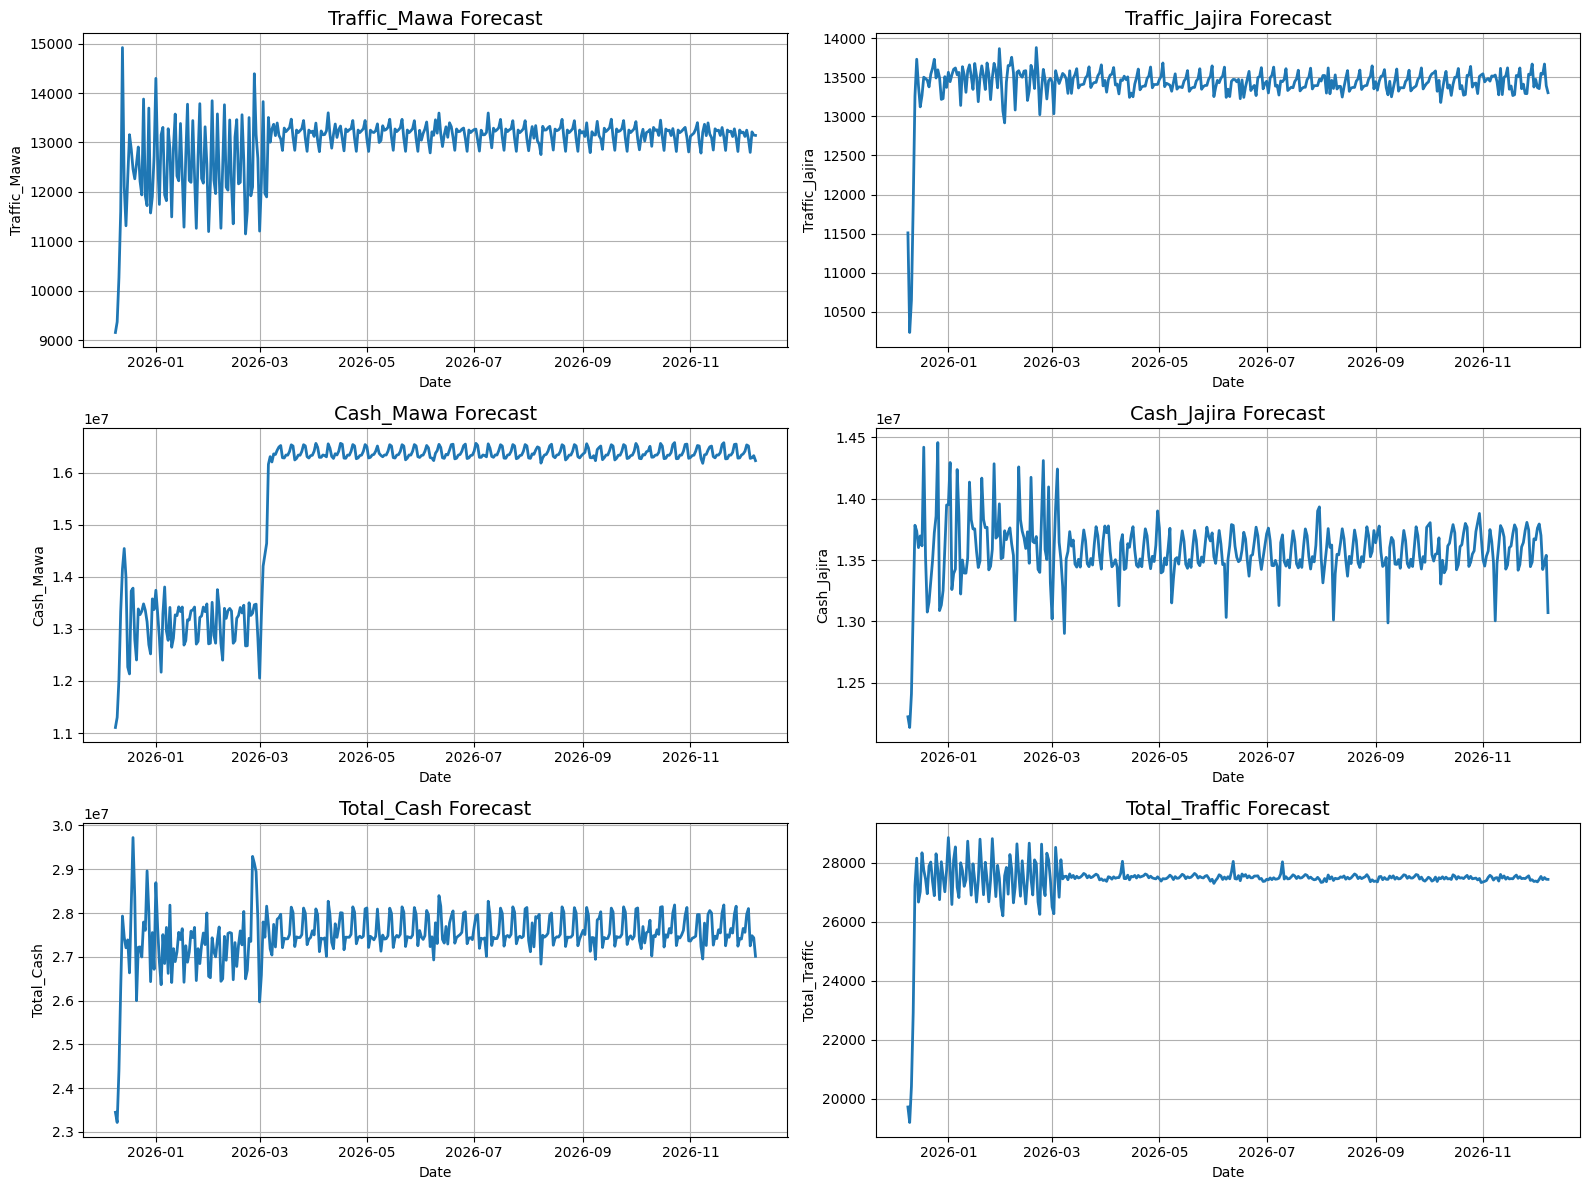

In [81]:
n_targets = len(target_cols)
n_cols = 2
n_rows = (n_targets + 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(target_cols):
    axes[i].plot(future_pred_df.index, future_pred_df[col], color='tab:blue', linewidth=2)
    axes[i].set_title(f'{col} Forecast', fontsize=14)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(col)
    axes[i].grid(True)

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [82]:
print("\n" + "="*60)
print("FORECAST SUMMARY")
print("="*60)
print(f"Forecast period: {future_dates[0].date()} to {future_dates[-1].date()}")
print(f"Number of days forecasted: {N_DAYS}")

for col in target_cols:
    forecast_data = future_pred_df[col]
    print(f"\n{col} Forecast Statistics:")
    print(f"  Mean: {forecast_data.mean():.2f}")
    print(f"  Std:  {forecast_data.std():.2f}")
    print(f"  Min:  {forecast_data.min():.2f}")
    print(f"  Max:  {forecast_data.max():.2f}")
    print(f"  Median: {forecast_data.median():.2f}")


FORECAST SUMMARY
Forecast period: 2025-12-09 to 2026-12-08
Number of days forecasted: 365

Traffic_Mawa Forecast Statistics:
  Mean: 13004.32
  Std:  594.41
  Min:  9156.39
  Max:  14920.29
  Median: 13200.02

Traffic_Jajira Forecast Statistics:
  Mean: 13417.67
  Std:  287.41
  Min:  10237.74
  Max:  13878.59
  Median: 13448.03

Cash_Mawa Forecast Statistics:
  Mean: 15607843.26
  Std:  1412281.41
  Min:  11107001.89
  Max:  16575635.54
  Median: 16327082.27

Cash_Jajira Forecast Statistics:
  Mean: 13578039.14
  Std:  244971.50
  Min:  12136971.58
  Max:  14456842.19
  Median: 13575337.99

Total_Cash Forecast Statistics:
  Mean: 27502389.28
  Std:  578663.98
  Min:  23217142.27
  Max:  29723208.84
  Median: 27461519.37

Total_Traffic Forecast Statistics:
  Mean: 27430.50
  Std:  811.07
  Min:  19187.73
  Max:  28859.43
  Median: 27489.39


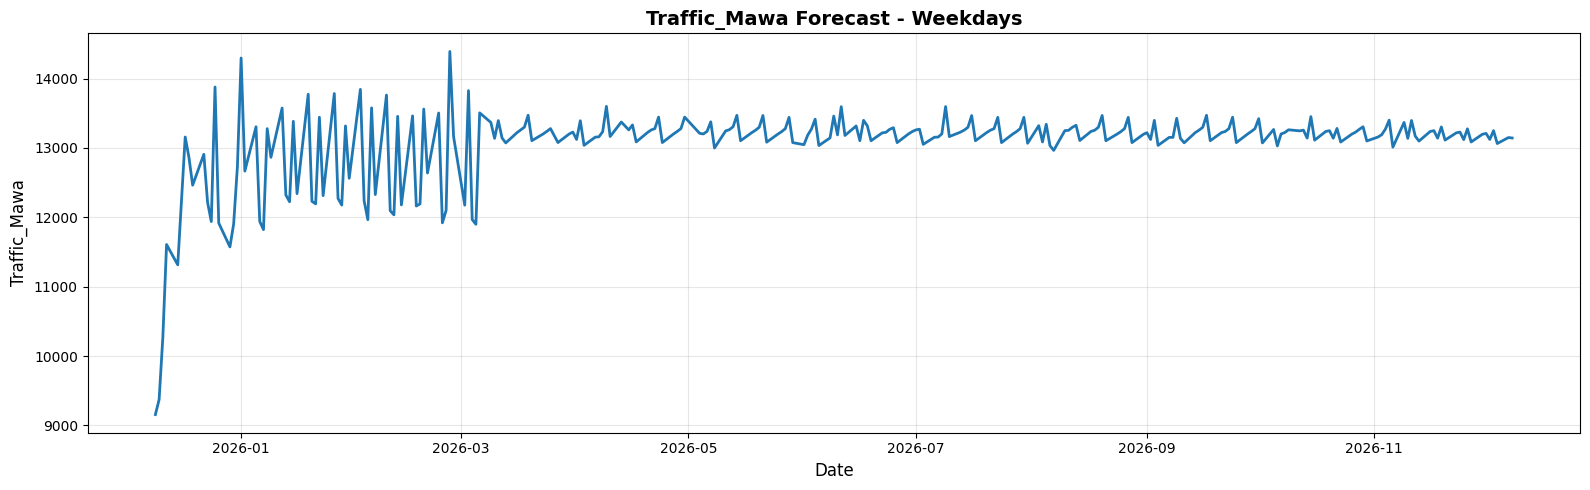

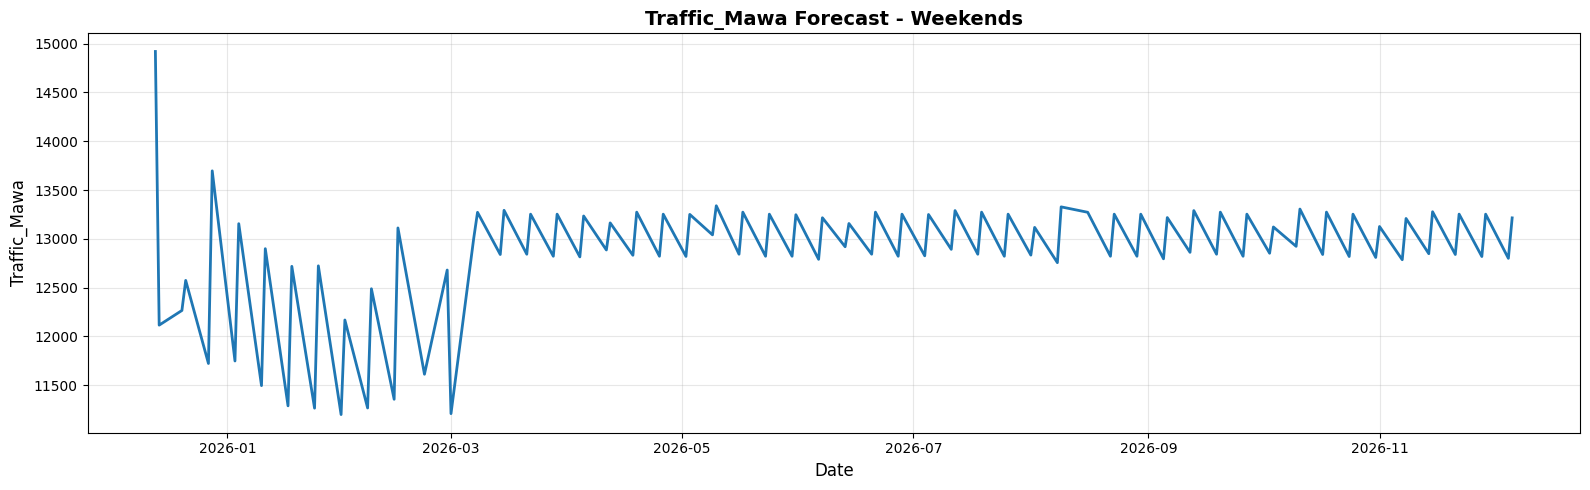

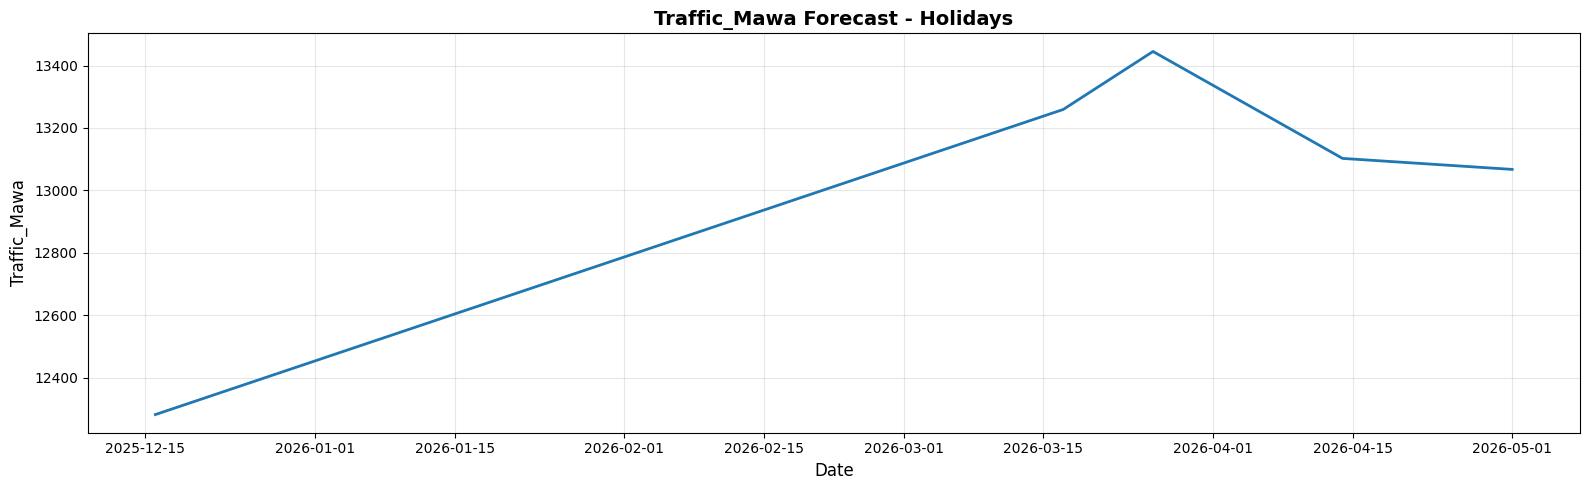

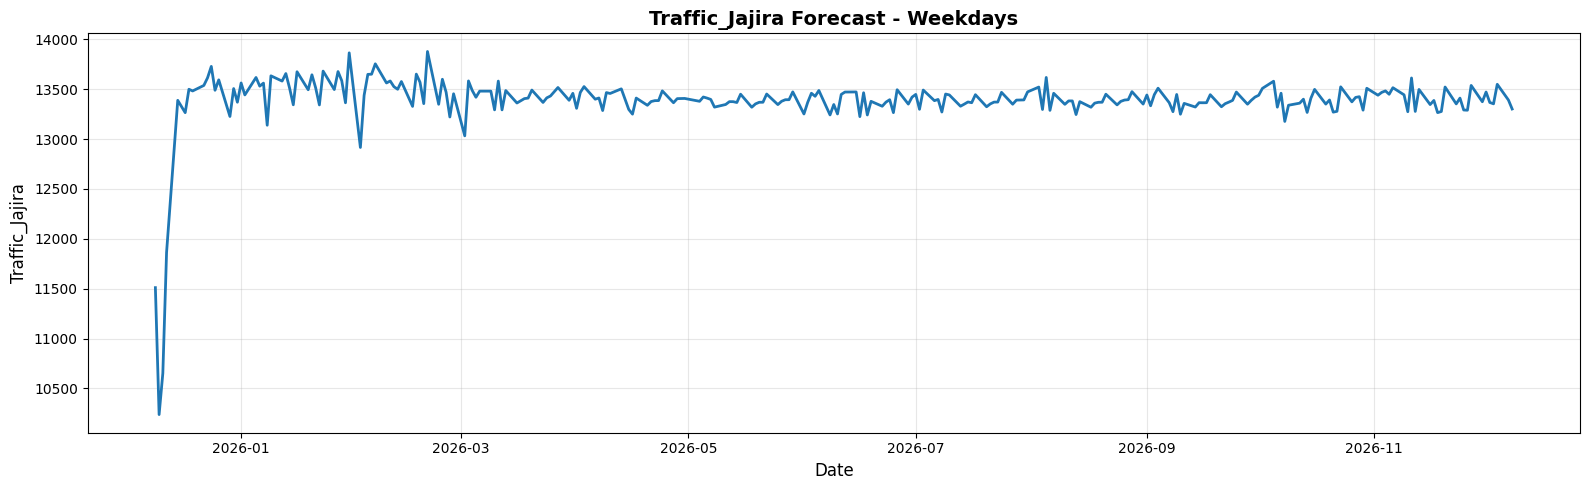

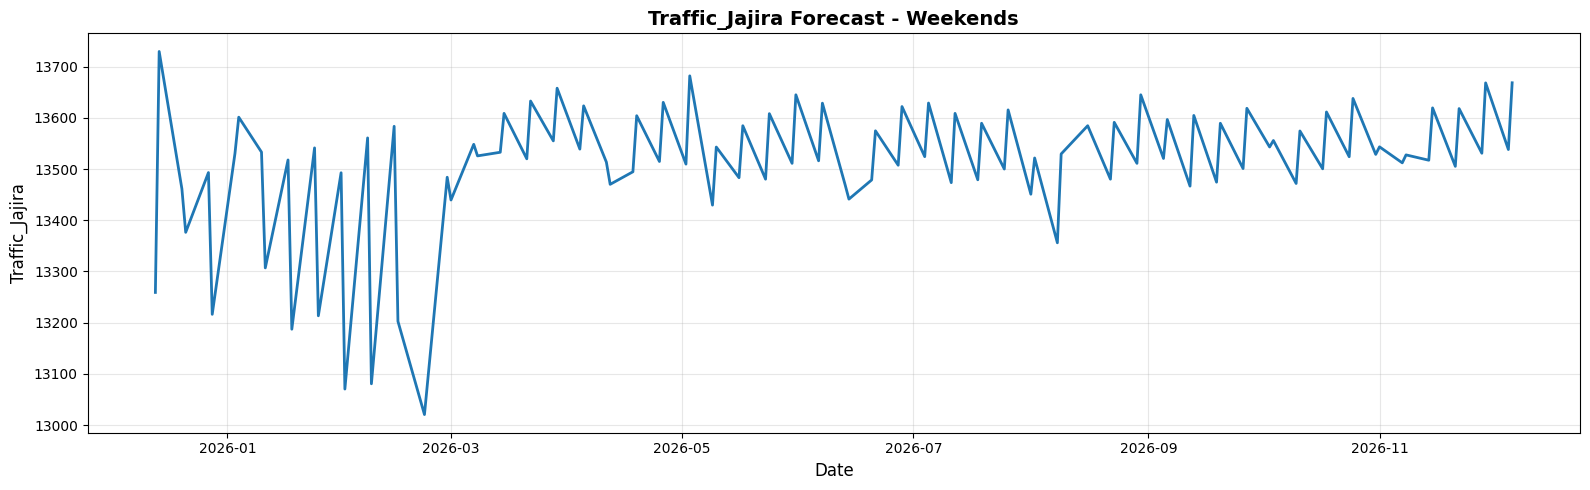

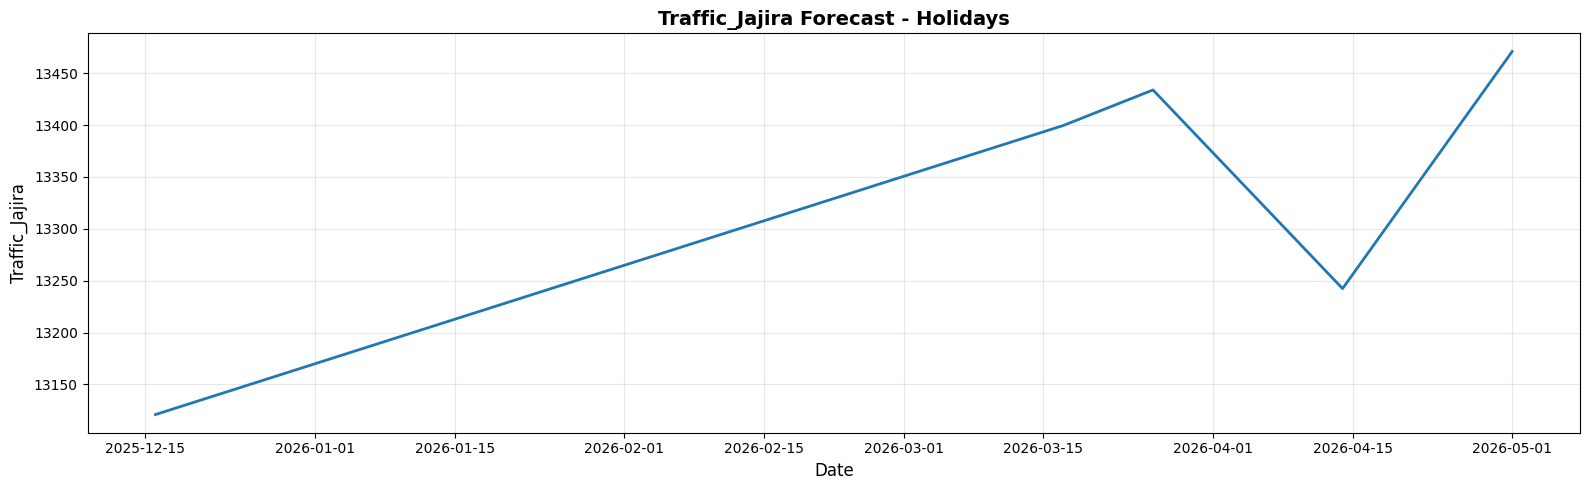

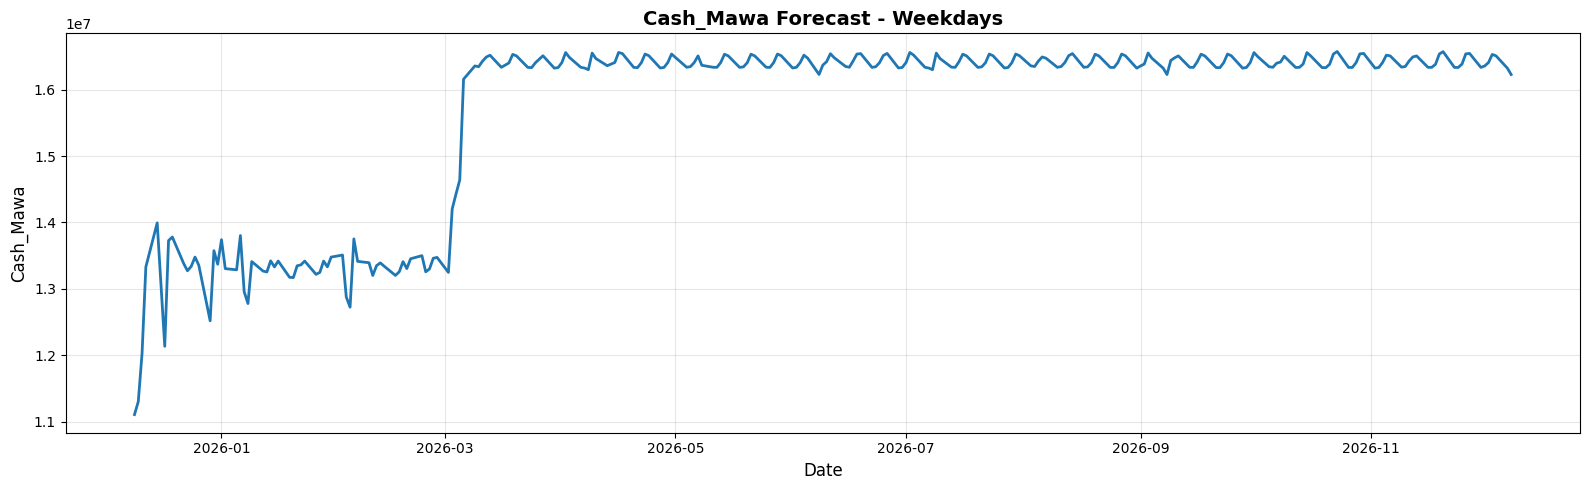

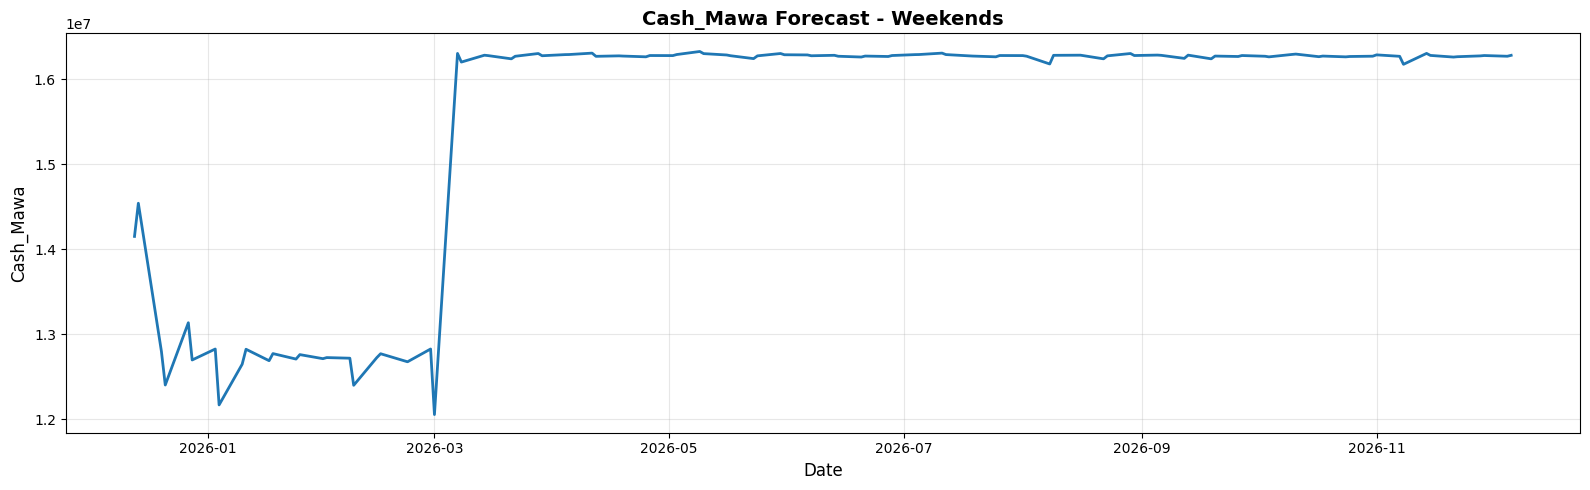

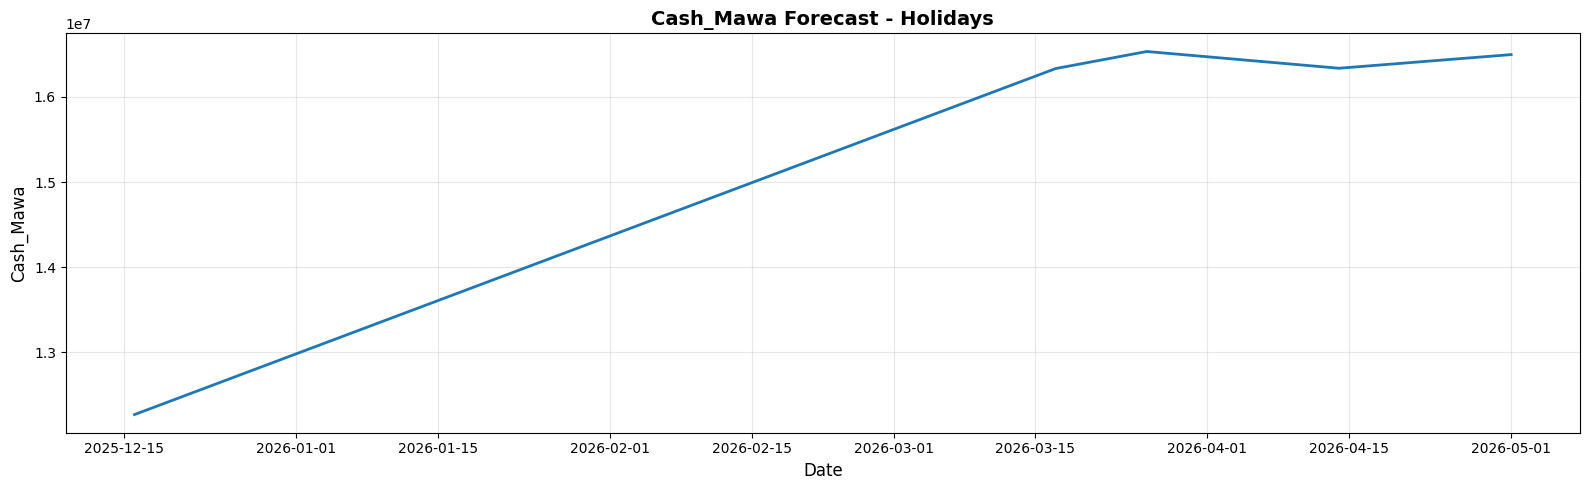

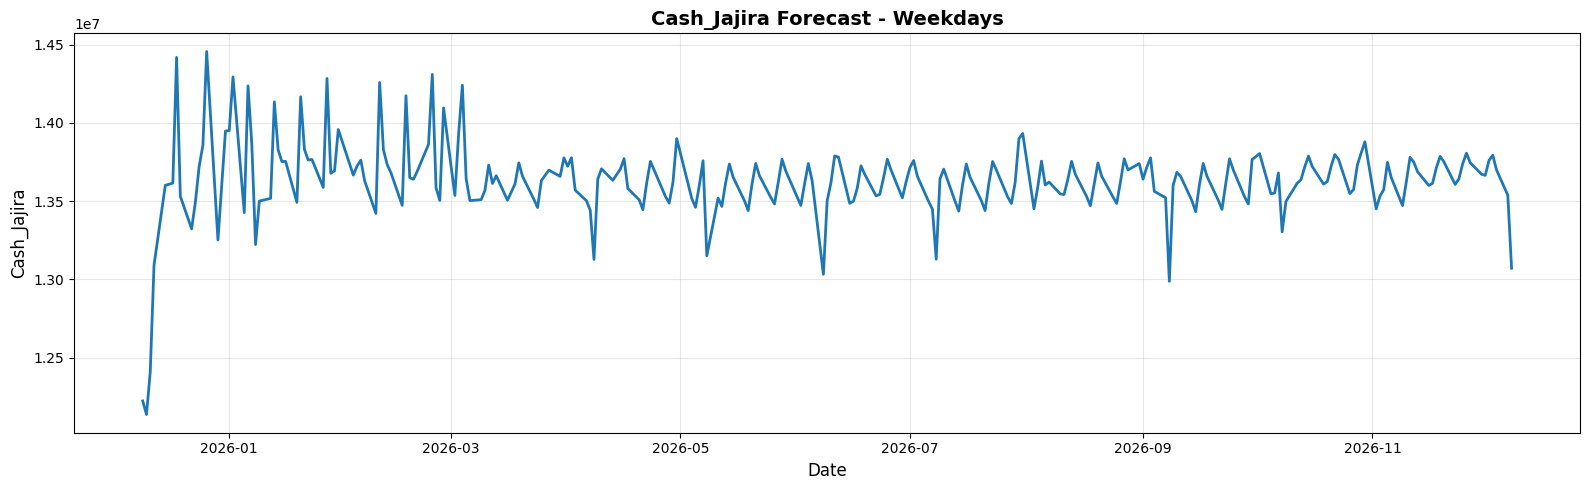

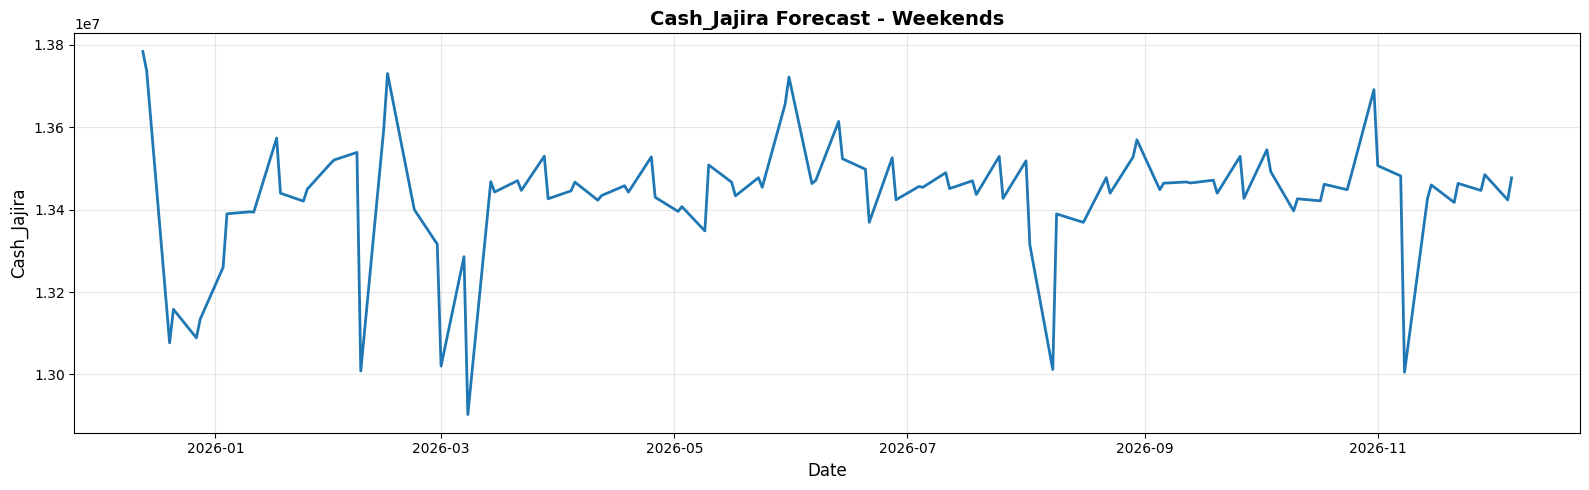

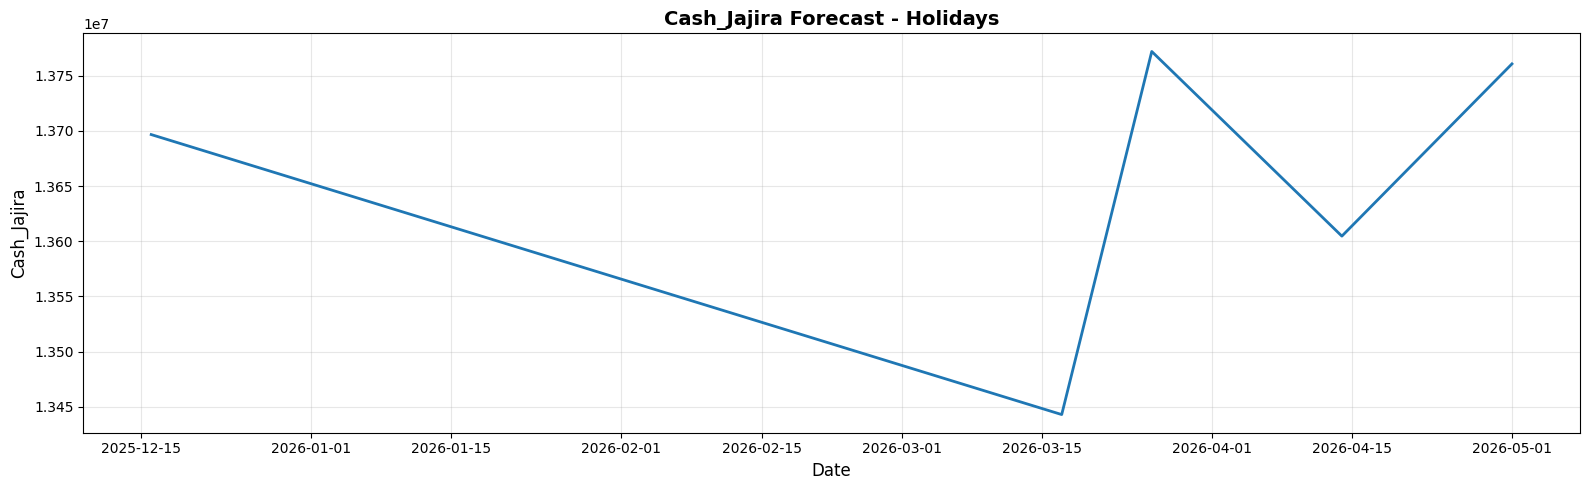

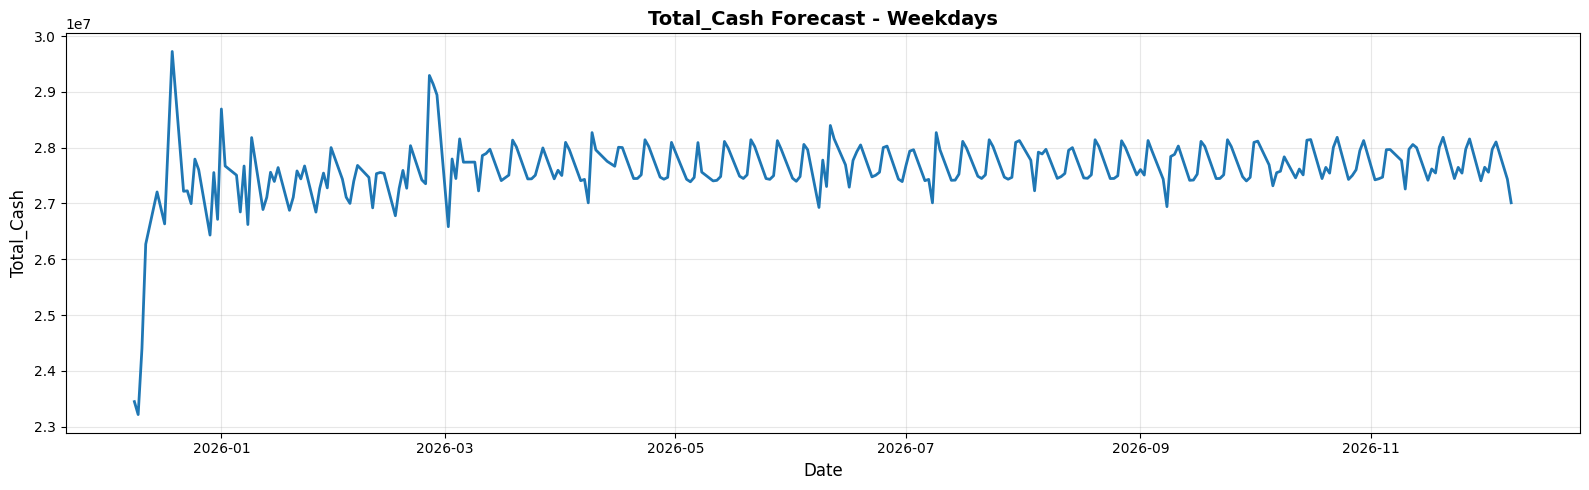

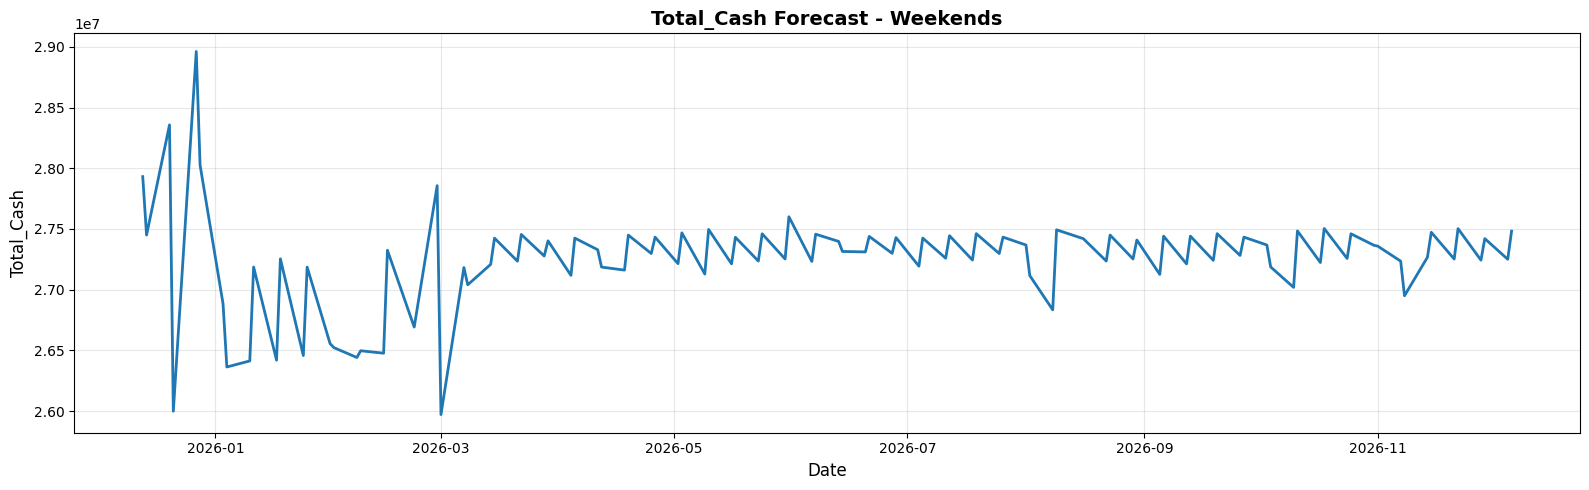

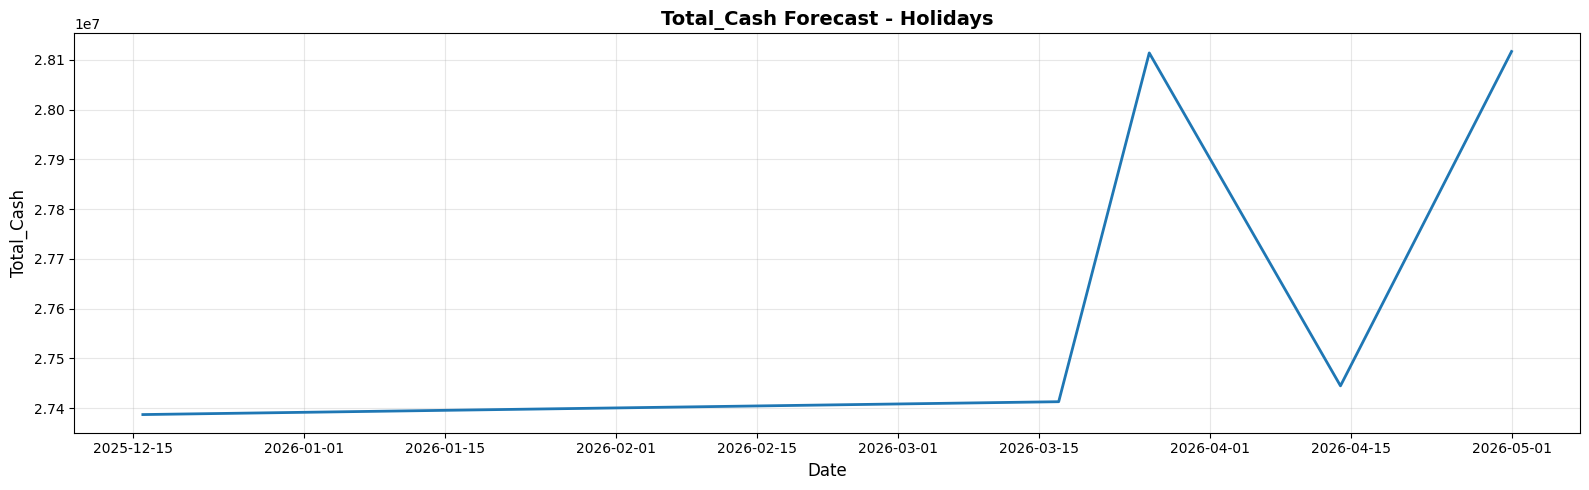

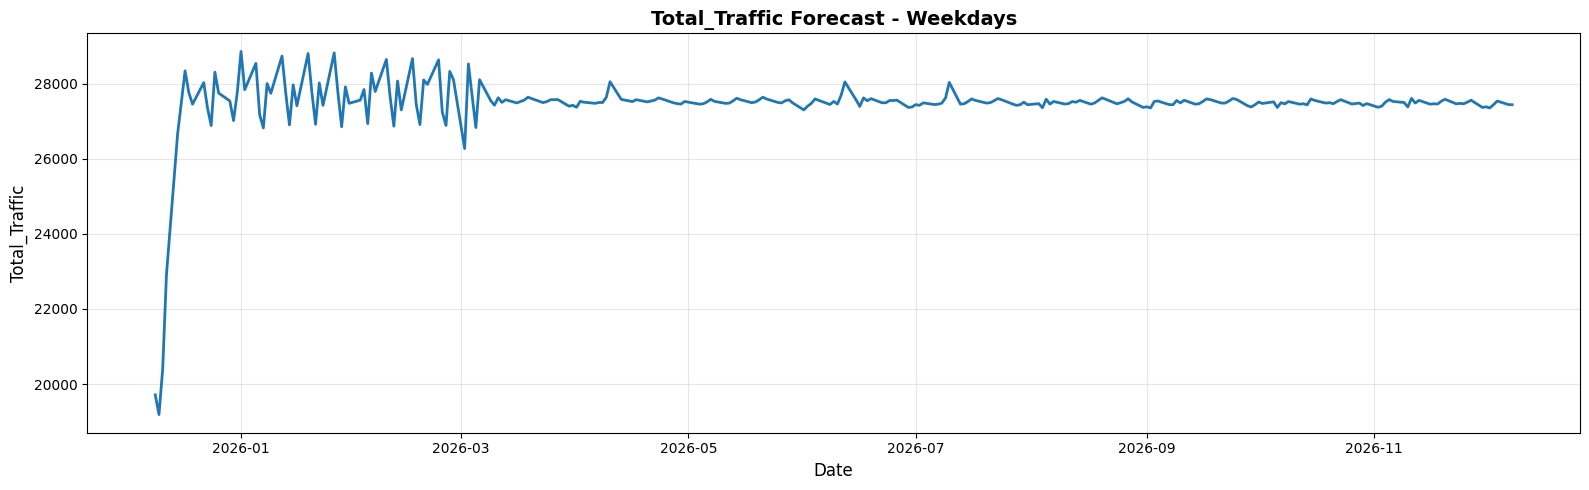

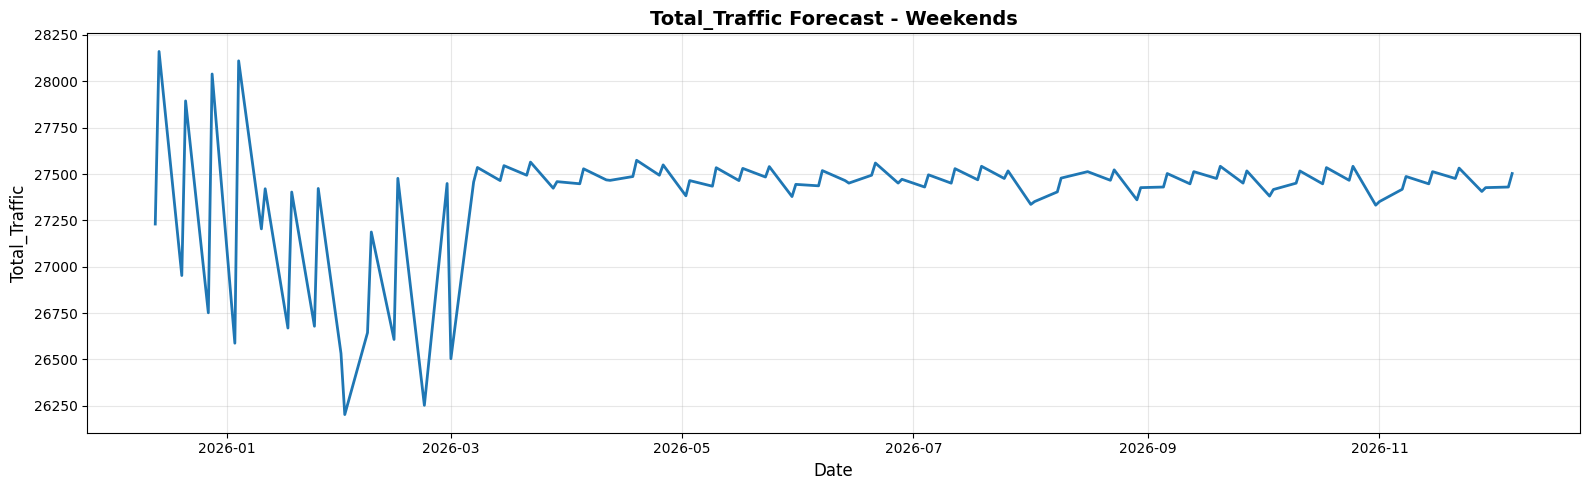

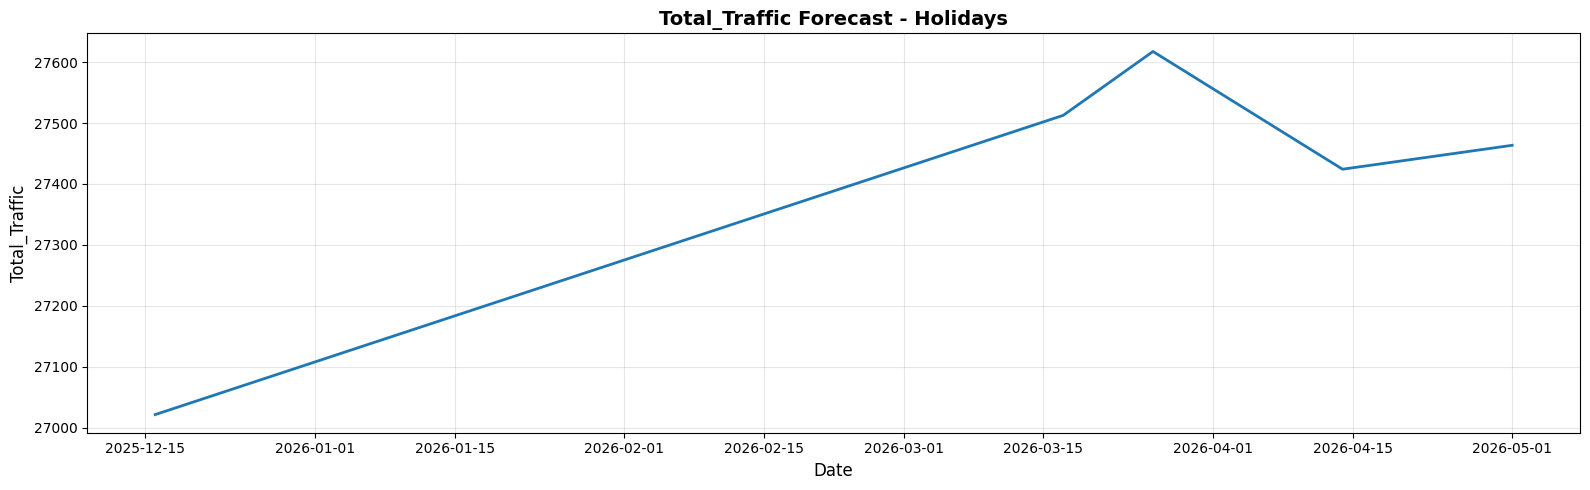

In [ ]:
import matplotlib.pyplot as plt

# Copy forecast df and add date/time features
df_plot = future_pred_df.copy()
df_plot['Date'] = df_plot.index
df_plot['DayOfWeek'] = df_plot.index.dayofweek
df_plot['isWeekend'] = df_plot['DayOfWeek'].isin([5,6])
df_plot['isHoliday'] = future_df['isHoliday'].values  

categories = {
    'Weekdays': df_plot[~df_plot['isWeekend'] & ~df_plot['isHoliday']],
    'Weekends': df_plot[df_plot['isWeekend'] & ~df_plot['isHoliday']],
    'Holidays': df_plot[df_plot['isHoliday'] & ~df_plot['isWeekend']],
}

for col in target_cols:
    for cat_name, cat_df in categories.items():
        plt.figure(figsize=(16,5))
        plt.plot(cat_df['Date'], cat_df[col], color='tab:blue', linewidth=2)
        plt.title(f'{col} Forecast - {cat_name}', fontsize=14, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel(col, fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
